In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import torch
import torchvision
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm
from utils import constants

In [2]:
if torch.cuda.is_available():
    device_num = torch.cuda.current_device()
    device = f'cuda:{device_num}'
else:
    device = 'cpu'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5),
    inplace=True),
])

In [66]:
dataset_A = datasets.ImageFolder('/shared/rsaas/nschiou2/CXR/data_demo/train/chexpert_A/', transform)
dataset_B = datasets.ImageFolder('/shared/rsaas/nschiou2/CXR/data_demo/train/chexpert_B/', transform)

### Test loading image

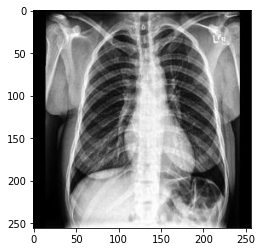

In [157]:
test_img = dataset_A[0][0]
test_img = (test_img + 1) / 2
plt.imshow(test_img.permute(1, 2, 0))

In [68]:
A_df = pd.read_parquet('sample_domain_A.parquet')
A_df = A_df.sort_values('Patient ID', axis=0).reset_index(drop=True)

patient_id = A_df.loc[0, 'Patient ID']
path = A_df.loc[0, 'Path']

im = Image.open('/shared/rsaas/nschiou2/CXR/data_demo/train/chexpert_A/normal/chex_No Finding_patient00004_6809.jpg')

In [69]:
path

'CheXpert-v1.0-small/train/patient00004/study1/view1_frontal.jpg'

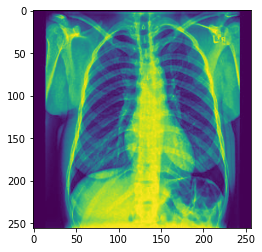

In [70]:
plt.imshow(im)

# Load model for embedding

In [15]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
A_loader = torch.utils.data.DataLoader(
    dataset_A,
    batch_size=16,
    num_workers=1,
    shuffle=False)
B_loader = torch.utils.data.DataLoader(
    dataset_B,
    batch_size=16,
    num_workers=1,
    shuffle=False)

In [17]:
embeddings_list = {'A': [], 'B': []}

tk0 = tqdm(A_loader, desc='Inference A')
for step, batch in enumerate(tk0):
    im, label = batch
    im = im.to(device)
    result = model(im)
    embeddings_list['A'].append(result.detach().cpu())
tk0 = tqdm(B_loader, desc='Inference B')
for step, batch in enumerate(tk0):
    im, label = batch
    im = im.to(device)
    result = model(im)
    embeddings_list['B'].append(result.detach().cpu())

Inference A:   0%|          | 0/1250 [00:00<?, ?it/s]

Inference B:   0%|          | 0/1250 [00:00<?, ?it/s]

In [18]:
embeddings_A = torch.vstack(embeddings_list['A'])
embeddings_B = torch.vstack(embeddings_list['B'])

In [19]:
X_A = embeddings_A.numpy()
X_B = embeddings_B.numpy()

In [20]:
np.save('sample_embedding_F.npy', X_A)
np.save('sample_embedding_M.npy', X_B)

# Load and visualize embeddings

In [74]:
domain_A = 'A'
domain_B = 'B'

n_plot = 1000

embedding_dir = os.path.join(constants.DEMO_DATA_DIR, 'train', 'embeddings')

A_df = pd.read_parquet(f'sample_domain_{domain_A}.parquet')
B_df = pd.read_parquet(f'sample_domain_{domain_B}.parquet')

A_df.drop_duplicates(subset='Patient ID', keep='first', inplace=True, ignore_index=True)
B_df.drop_duplicates(subset='Patient ID', keep='first', inplace=True, ignore_index=True)

A_embed = pd.read_parquet(os.path.join(embedding_dir, f'embedding_chexpert_{domain_A}.parquet'))
B_embed = pd.read_parquet(os.path.join(embedding_dir, f'embedding_chexpert_{domain_B}.parquet'))

A_embed = A_embed.merge(A_df, how='left', on='Patient ID')
B_embed = B_embed.merge(B_df, how='left', on='Patient ID')

In [75]:
A_embed = A_embed[(A_embed['AP/PA'] == 'AP') & (A_embed['Cardiomegaly'] == 1)].reset_index(drop=True)
B_embed = B_embed[(B_embed['AP/PA'] == 'AP') & (B_embed['Cardiomegaly'] == 1)].reset_index(drop=True)

In [76]:
A_idx = A_embed.index
B_idx = B_embed.index

In [77]:
idx_A = np.array(list(A_idx))
np.random.seed(8)
np.random.shuffle(idx_A)
idx_A = idx_A[:n_plot]

idx_B = np.array(list(B_idx))
np.random.shuffle(idx_B)
idx_B = idx_B[:n_plot]

In [78]:
X_A = A_embed[[c for c in A_embed.columns if 'resnet' in c]].values
X_B = B_embed[[c for c in B_embed.columns if 'resnet' in c]].values

In [79]:
X = np.concatenate([X_A[idx_A, :], X_B[idx_B, :]], axis=0)

In [80]:
import sklearn.decomposition
import sklearn.manifold
import sklearn.preprocessing
import umap

use_PCA = False
scale = True
visualization = 'UMAP'

if use_PCA:
    pca = sklearn.decomposition.PCA(n_components=50, random_state=8)
    X_mean = np.mean(X, axis=0)
    X = pca.fit_transform(X - X_mean)
if scale:
    scaler = sklearn.preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
if visualization == 'T-SNE':
    tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=8)
    X_new = tsne.fit_transform(X)
elif visualization == 'UMAP':
    umap = umap.UMAP()
    X_new = umap.fit_transform(X)

In [81]:
A_embed_subset = A_embed.loc[idx_A]
B_embed_subset = B_embed.loc[idx_B]

In [82]:
A_embed_subset.loc[:, 'embedding_0'] = X_new[:n_plot, 0]
A_embed_subset.loc[:, 'embedding_1'] = X_new[:n_plot, 1]
A_embed_subset.loc[:, 'domain'] = domain_A

B_embed_subset.loc[:, 'embedding_0'] = X_new[n_plot:, 0]
B_embed_subset.loc[:, 'embedding_1'] = X_new[n_plot:, 1]
B_embed_subset.loc[:, 'domain'] = domain_B

combined_df = pd.concat([A_embed_subset, B_embed_subset], axis=0)

In [83]:
combined_df.columns

Index(['Patient ID', 'resnet_dim_0', 'resnet_dim_1', 'resnet_dim_2',
       'resnet_dim_3', 'resnet_dim_4', 'resnet_dim_5', 'resnet_dim_6',
       'resnet_dim_7', 'resnet_dim_8',
       ...
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'Primary Race', 'Ethnicity', 'embedding_0',
       'embedding_1', 'domain'],
      dtype='object', length=2073)

In [84]:
combined_df.loc[combined_df['Cardiomegaly'] == 1, 'label'] = 'x_car'

In [85]:
combined_df.loc[combined_df['No Finding'] == 1, 'label'] = 'normal'

<AxesSubplot:xlabel='embedding_0', ylabel='embedding_1'>

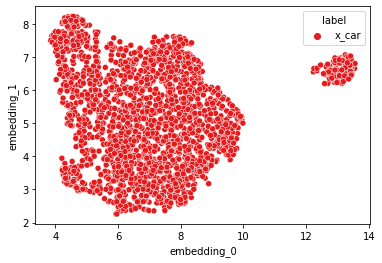

In [86]:
sns.scatterplot(data=combined_df, x='embedding_0', y='embedding_1', hue='label', palette='Set1')

<AxesSubplot:xlabel='embedding_0', ylabel='embedding_1'>

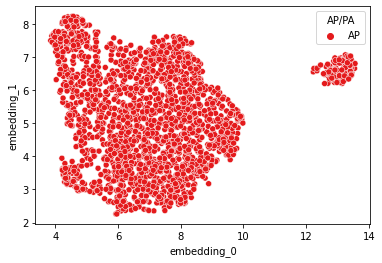

In [87]:
sns.scatterplot(data=combined_df, x='embedding_0', y='embedding_1', hue='AP/PA', palette='Set1')

<AxesSubplot:xlabel='embedding_0', ylabel='embedding_1'>

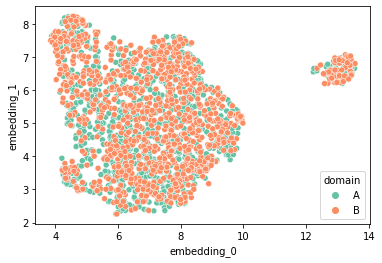

In [88]:
sns.scatterplot(data=combined_df, x='embedding_0', y='embedding_1', hue='domain', palette='Set2')

<AxesSubplot:xlabel='embedding_0', ylabel='embedding_1'>

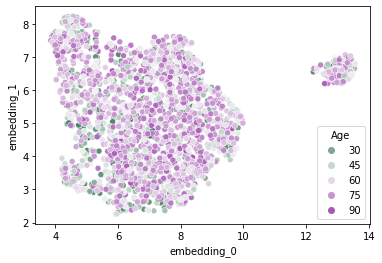

In [89]:
sns.scatterplot(data=combined_df, x='embedding_0', y='embedding_1', hue='Age', palette=sns.diverging_palette(145, 300, s=60, as_cmap=True))

<AxesSubplot:xlabel='embedding_0', ylabel='embedding_1'>

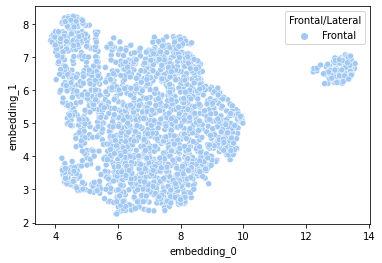

In [90]:
sns.scatterplot(data=combined_df, x='embedding_0', y='embedding_1', hue='Frontal/Lateral', palette='pastel')

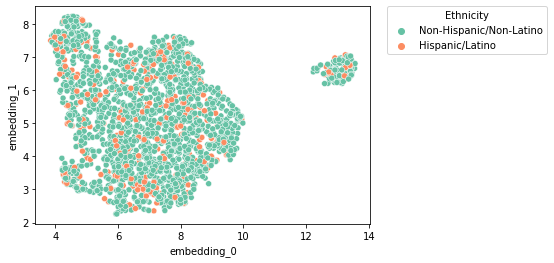

In [91]:
sns.scatterplot(data=combined_df, x='embedding_0', y='embedding_1', hue='Ethnicity', palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Ethnicity')

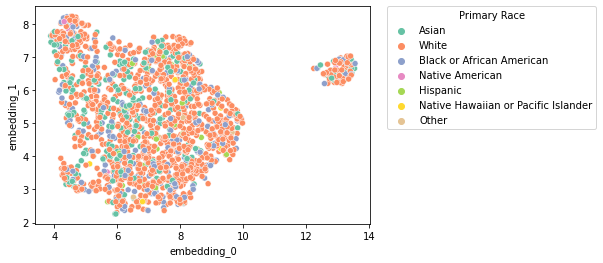

In [92]:
sns.scatterplot(data=combined_df, x='embedding_0', y='embedding_1', hue='Primary Race', palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Primary Race')